## _Data Science Problem_

The purpose of this data science project is to come up with a model to predict the applainces energy usage based on consumner's house temperature and humidity conditions plus outside enviromental conditions 

###### This step focuses on creating and testing models for our data, as well as creating predictions and model performance evaluation. Hyperparameter tuning is also performed. 


# **_Importing libraries_**

In [8]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 


import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# Loading Cleaned Data  

**_Loading Appliances Energy Usage Data_**

In [17]:
df= pd.read_csv('C:/Users/msale/Documents/Springboard Data Science Track_Jan 2022/Springboard-Capstone-Two/Data_Files/appliances_clean_df.csv')

In [18]:
df['date'] = pd.to_datetime(df['date'])

In [19]:
df.head()

,date,Appliances_E_Wh,Lights_E_Wh,T_Kitchen,H_Kitchen,T_Living,H_Living,T_Laundry,H_Laundry,T_Office,...,T_Teenager,H_Teenager,T_Parents,H_Parents,T_out,Press_out,H_out,Windspeed,Visibility,Tdewpoint
0,2016-01-11 17:00:00,4.094345,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,2016-01-11 17:10:00,4.094345,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,2016-01-11 17:20:00,3.912023,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,2016-01-11 17:30:00,3.912023,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,2016-01-11 17:40:00,4.094345,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


# Exploring the correlations of features with the target variable

In [8]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Appliances_E_Wh', data= df, alpha=0.5)
        ax.set(xlabel=col, ylabel='Appliances_E_Wh')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [9]:
features = [column for column in df.columns if column not in ['date', 'Appliances_E_Wh']]

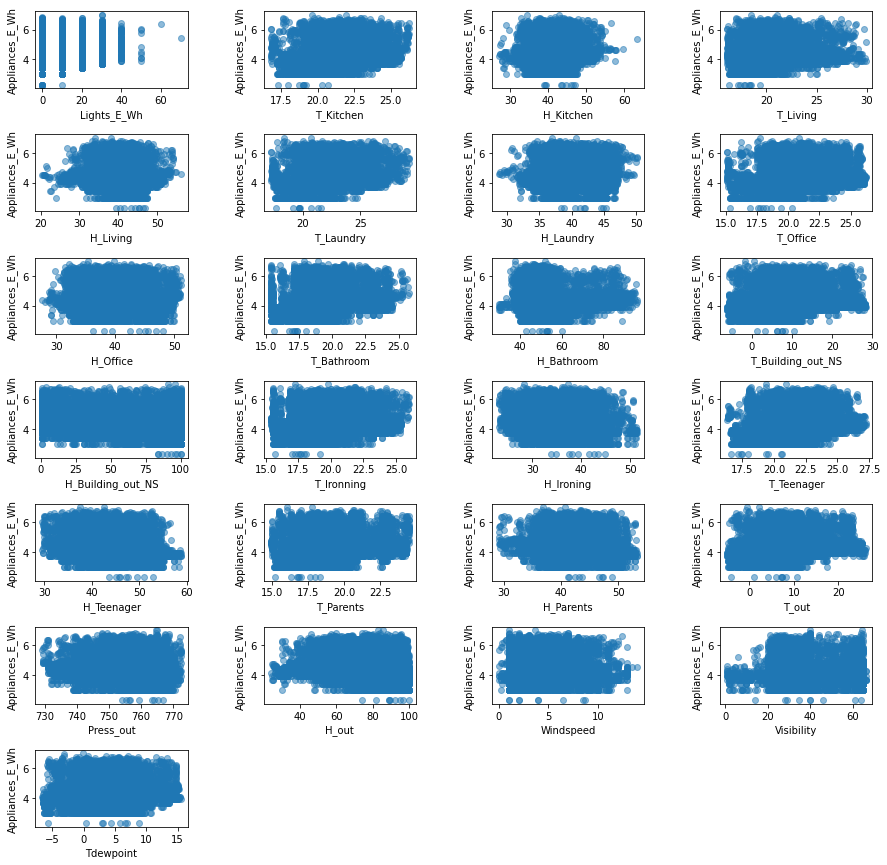

In [10]:
scatterplots(features, ncol=4, figsize=(15, 15))

## Defining features (X ) and target variables (y)

In [40]:
y = df['Appliances_E_Wh']  

X = df.drop(["Appliances_E_Wh", "date"], axis=1)  # considering all the numeric variables  

In [41]:
X.head()

,Lights_E_Wh,T_Kitchen,H_Kitchen,T_Living,H_Living,T_Laundry,H_Laundry,T_Office,H_Office,T_Bathroom,...,T_Teenager,H_Teenager,T_Parents,H_Parents,T_out,Press_out,H_out,Windspeed,Visibility,Tdewpoint
0,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [13]:
y.head()

0    4.094345
1    4.094345
2    3.912023
3    3.912023
4    4.094345
Name: Appliances_E_Wh, dtype: float64

In [92]:
y.describe()

count    19735.000000
mean         4.303707
std          0.656307
min          2.302585
25%          3.912023
50%          4.094345
75%          4.605170
max          6.984716
Name: Appliances_E_Wh, dtype: float64

## _Creating a 70/30 train and test split_

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13814, 25), (5921, 25), (13814,), (5921,))

## Using Sklearn, standarizing the magnitude of the features by scaling the values.

_Note: We need to fit() our scaler on X_train and then use that fitted scaler to transform() X_test. This is to avoid data leakage while we standardize our data_

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
X_train_scaled.shape, X_test_scaled.shape

((13814, 25), (5921, 25))

In [18]:
y_train.shape, y_test.shape

((13814,), (5921,))

In [19]:
y_train.dtypes

dtype('float64')

In [20]:
X_train_scaled.mean(), X_train_scaled.std() # verifying scaling: mean should be zero, std would be one

(1.6068738283730658e-16, 1.0000000000000002)

# Modeling 

**Performance Summary**
 

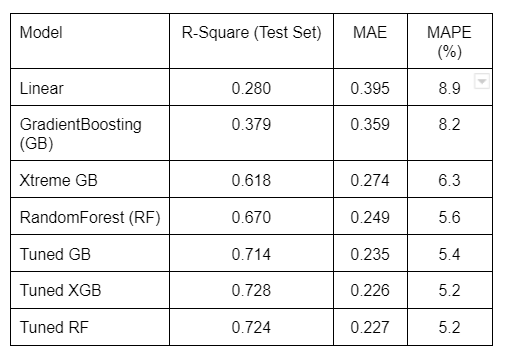


##    1) Linear Regression Model 

In [46]:
lm = linear_model.LinearRegression()

In [47]:
lm.fit(X_train_scaled, y_train)

LinearRegression()

In [48]:
y_tr_pred = lm.predict(X_train_scaled)

In [49]:
y_pred_lm = lm.predict(X_test_scaled)

In [50]:
lm.intercept_

4.304241074952765

In [51]:
lm.get_params(deep=True)

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

### 1.1) Feature Importance

In [52]:
lm.coef_

array([ 0.13074235,  0.02672969,  0.43116503, -0.21311231, -0.33607356,
        0.30683661,  0.08140753, -0.04651039, -0.0162244 ,  0.00732276,
        0.02673439,  0.32004103,  0.08621609, -0.05276893, -0.0285307 ,
        0.19720284, -0.23585263, -0.22133185, -0.05529019, -0.40074226,
       -0.0007652 , -0.13195244,  0.03486214,  0.01165166,  0.17638895])

In [53]:
coef = pd.DataFrame(lm.coef_ , index = X_train.columns, columns = ['Coef'])
coef.abs().sort_values(by = ['Coef'], ascending = False)

,Coef
H_Kitchen,0.431165
T_out,0.400742
H_Living,0.336074
T_Building_out_NS,0.320041
T_Laundry,0.306837
H_Teenager,0.235853
T_Parents,0.221332
T_Living,0.213112
T_Teenager,0.197203
Tdewpoint,0.176389


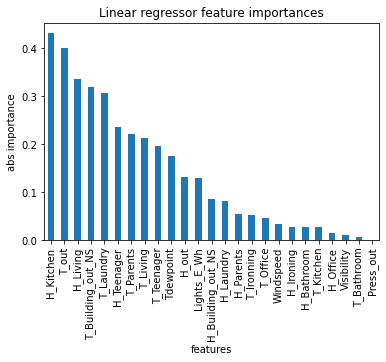

In [54]:
pd.Series(lm.coef_, index=X_train.columns).abs().sort_values(ascending= False).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('abs importance')
plt.title('Linear regressor feature importances');

#### The top six features from Linear model are: 

H_Kitchen, T_out, H_Living, T_Building_out_NS, T_Laundry, H_Teenager

### 1.2) Comparing Prediction and Actual Values from Linear Model 

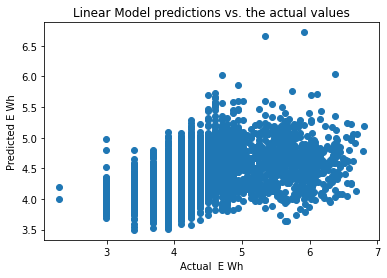

In [55]:
plt.scatter(y_test,y_pred_lm)
plt.title("Linear Model predictions vs. the actual values")
plt.xlabel('Actual  E Wh')
plt.ylabel('Predicted E Wh');

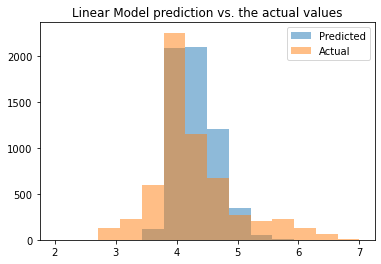

In [56]:
bins = np.linspace(2, 7, 15)
plt.title("Linear Model prediction vs. the actual values")
plt.hist(y_pred_lm , bins, alpha=0.5, label='Predicted')
plt.hist(y_test, bins, alpha=0.5, label='Actual')
plt.legend(loc='upper right')
plt.show()

#### Linear model underestimates the smaller values and tend to overestimate the middle range target values

### 1.3) Model Performance

In [57]:
lm.score(X_train_scaled, y_train)  # training set accuracy 

0.27122441785249796

In [58]:
r2_score(y_train, y_tr_pred) # confirming training set accuracy using r2_score function

0.27122441785249796

###### The above score is called R-Squared coefficient, or the "coefficient of determination". It's basically a measure of how successfully our model predicts the variations in the data away from the mean: 1 would mean a perfect model that explains 100% of the variation. Zero means that model is not doing better than estimating just the average. At the moment, our model explains only about 27% of the variation from the mean. There's more work to do!

In [59]:
lm.score(X_test_scaled, y_test) # test set accuracy 

0.28012300902707965

In [60]:
r2_score(y_test, y_pred_lm) # confirming test set accuracy using r2_score

0.28012300902707965

In [61]:
mae_lm = mean_absolute_error(y_test, y_pred_lm)  # MAE on the test set
mae_lm

0.3953955328312127

In [62]:
mape_lm = mean_absolute_percentage_error(y_test, y_pred_lm)  # 8.98 % error
mape_lm

0.08983428057623849

## 2) RandomForest

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
rf = RandomForestRegressor(random_state=42)

In [69]:
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [70]:
y_pred_rf= rf.predict(X_test_scaled)

In [71]:
rf.base_estimator_

DecisionTreeRegressor()

In [72]:
rf.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### 2.1) Feature Importance

In [73]:
rf.feature_importances_

array([0.07401926, 0.02302623, 0.06475373, 0.04607848, 0.03929353,
       0.04162365, 0.04148919, 0.03141293, 0.03010233, 0.03688736,
       0.04024956, 0.03100159, 0.03915831, 0.02214954, 0.03215455,
       0.04389885, 0.06467653, 0.02792083, 0.03943254, 0.02404528,
       0.04887636, 0.07704397, 0.02872469, 0.01914757, 0.03283312])

In [74]:
rf_coef= pd.DataFrame(rf.feature_importances_ , index = X.columns, columns = ['Coef'])
rf_coef.sort_values(by = ['Coef'], ascending = False)

,Coef
H_out,0.077044
Lights_E_Wh,0.074019
H_Kitchen,0.064754
H_Teenager,0.064677
Press_out,0.048876
T_Living,0.046078
T_Teenager,0.043899
T_Laundry,0.041624
H_Laundry,0.041489
H_Bathroom,0.040250


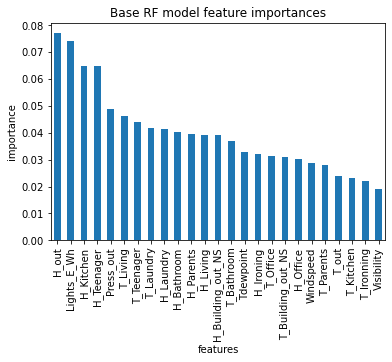

In [75]:
pd.Series(rf.feature_importances_, index=X_train.columns).abs().sort_values(ascending= False).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Base RF model feature importances');

#### The top six features from RF model are:

H_out, Lights_E_Wh, H_Kitchen, H_Teenager, Press_out, and T_Living. 

### 2.2) Comparing Prediction and Actual Values from RF Model

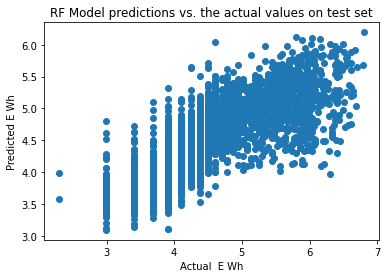

In [208]:
plt.scatter(y_test,y_pred_rf)
plt.title("RF Model predictions vs. the actual values on test set")
plt.xlabel('Actual  E Wh')
plt.ylabel('Predicted E Wh');

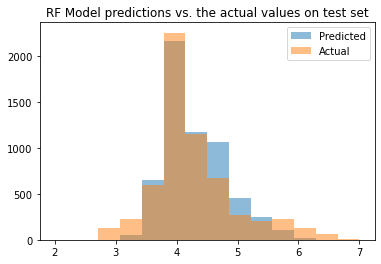

In [209]:
bins = np.linspace(2, 7, 15)
plt.title("RF Model predictions vs. the actual values on test set")
plt.hist(y_pred_rf , bins, alpha=0.5, label='Predicted')
plt.hist(y_test, bins, alpha=0.5, label='Actual')
plt.legend(loc='upper right')
plt.show()

#### RF model performs much better than the linear model, as expected. 

### 2.3) Model Performance

In [206]:
rf_tr_score = rf.score(X_train_scaled, y_train)  # training set accuracy 
rf_tr_score

0.9524085408005647

In [207]:
rf_te_score =rf.score(X_test_scaled, y_test)  # test set accuracy 
rf_te_score

0.6705514605411975

In [210]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_rf

0.2496448159904414

In [211]:
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mape_rf

0.056918705750176296

## 3) Tuned RandomForest (After Hyperparameter tunning)

In [17]:
rf_tuned = RandomForestRegressor(n_estimators= 400, min_samples_split = 2, min_samples_leaf =1, max_features ='sqrt',
 max_depth= None, bootstrap= False)

In [56]:
rf_tuned.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

In [57]:
y_pred_rf_tuned= rf_tuned.predict(X_test_scaled)

In [62]:
rf_tuned.get_params(deep=True)

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### 3.1) Feature Importance

In [58]:
rf_tuned.feature_importances_

array([0.05936674, 0.03072522, 0.0502082 , 0.05141714, 0.03760705,
       0.04092757, 0.04268389, 0.03454305, 0.03625803, 0.03574743,
       0.04071512, 0.04092013, 0.04565937, 0.03107983, 0.03951834,
       0.04148396, 0.05685315, 0.03113621, 0.04368975, 0.03458313,
       0.04506668, 0.04796709, 0.02795244, 0.01802472, 0.03586575])

In [59]:
rf_tuned_coef= pd.DataFrame(rf_tuned.feature_importances_ , index = X.columns, columns = ['Coef'])
rf_tuned_coef.sort_values(by = ['Coef'], ascending = False)

,Coef
Lights_E_Wh,0.059367
H_Teenager,0.056853
T_Living,0.051417
H_Kitchen,0.050208
H_out,0.047967
H_Building_out_NS,0.045659
Press_out,0.045067
H_Parents,0.043690
H_Laundry,0.042684
T_Teenager,0.041484


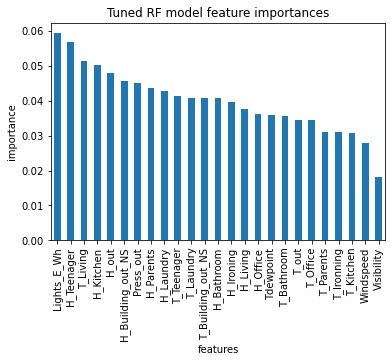

In [61]:
pd.Series(rf_tuned.feature_importances_, index=X_train.columns).abs().sort_values(ascending= False).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Tuned RF model feature importances');

#### The top six features from Tuned RF model are:

Lights_E_Wh, H_Teenager, T_Living, H_Kitchen, H_out, and H_Building_out_NS. 

##### We get better results from the tuned model

### 3.2) Comparing Prediction and Actual Values from Tuned RF model

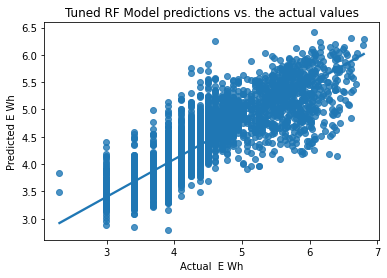

In [219]:
sns.regplot(y_test,y_pred_rf_tuned)
plt.title("Tuned RF Model predictions vs. the actual values")
plt.xlabel('Actual  E Wh')
plt.ylabel('Predicted E Wh');

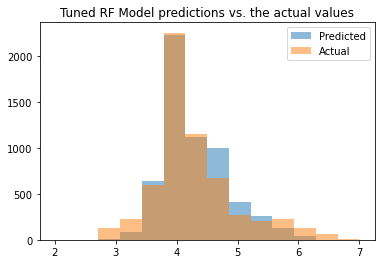

In [223]:
bins = np.linspace(2, 7, 15)
plt.title("Tuned RF Model predictions vs. the actual values")
plt.hist(y_pred_rf_tuned , bins, alpha=0.5, label='Predicted')
plt.hist(y_test, bins, alpha=0.5, label='Actual')
plt.legend(loc='upper right')
plt.show()

### 3.3) Model Performance and Comparision to Base RF Model 

In [63]:
rf_tuned_tr_score = rf_tuned.score(X_train_scaled, y_train)  # training set accuracy 
rf_tuned_tr_score

1.0

In [65]:
rf_tuned_te_score = rf_tuned.score(X_test_scaled, y_test)  # test set accuracy 
rf_tuned_te_score

0.7240074971288133

In [64]:
100*(rf_tuned_tr_score - rf_tr_score)/ rf_tr_score  # 5% improvement in R2 score on training set

4.996958464844448

In [66]:
100*(rf_tuned_te_score - rf_te_score)/rf_te_score # 7.97% improvement in R2 score on test set

7.971951406156325

In [69]:
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mae_rf_tuned

0.22729910896023908

In [70]:
100 * (mae_rf-mae_rf_tuned)/ mae_rf  # about 8.95% improvement in MAE score 

8.950999820103574

In [71]:
mape_rf_tuned = mean_absolute_percentage_error(y_test, y_pred_rf_tuned)
mape_rf_tuned

0.05205280321972776

In [72]:
100 * (mape_rf-mape_rf_tuned)/ mape_rf # about 8.5% improvement in MAPE score

8.548863622805523

# 4) GradientBoosting

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [5]:
gb = GradientBoostingRegressor(random_state = 42)

In [75]:
gb.fit(X_train_scaled, y_train.values.ravel())

GradientBoostingRegressor(random_state=42)

In [76]:
y_pred_gb = gb.predict(X_test_scaled) 

In [77]:
gb.get_params(deep=True)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### 4.1) Feature Importance

In [78]:
gb_coef= pd.DataFrame(gb.feature_importances_ , index = X.columns, columns = ['Coef'])
gb_coef.sort_values(by = ['Coef'], ascending = False)

,Coef
Lights_E_Wh,0.152708
H_out,0.092066
H_Teenager,0.081191
H_Kitchen,0.072817
T_Living,0.071424
T_Laundry,0.055518
H_Parents,0.047459
H_Laundry,0.042837
T_Parents,0.042569
T_Teenager,0.040289


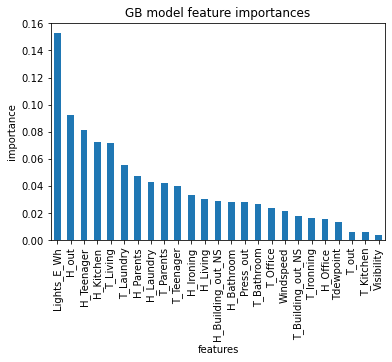

In [92]:
pd.Series(gb.feature_importances_, index=X_train.columns).abs().sort_values(ascending= False).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('GB model feature importances');

#### The top six features from GB model are:

Lights_E_Wh, H_out, H_Teenager, H_Kitchen, T_Living, T_Laundry	

### 4.2) Comparing Prediction and Actual Values from GB model

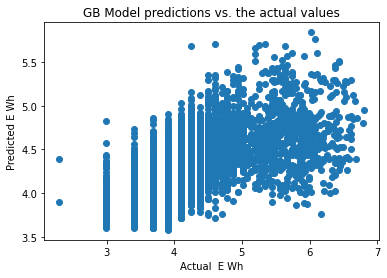

In [82]:
plt.scatter(y_test,y_pred_gb)
plt.title("GB Model predictions vs. the actual values")
plt.xlabel('Actual  E Wh')
plt.ylabel('Predicted E Wh');

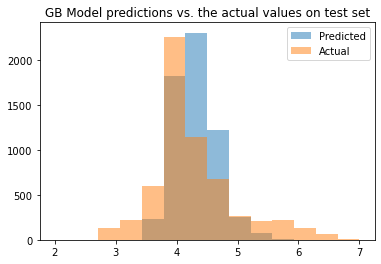

In [83]:
bins = np.linspace(2, 7, 15)
plt.title("GB Model predictions vs. the actual values on test set")
plt.hist(y_pred_gb , bins, alpha=0.5, label='Predicted')
plt.hist(y_test, bins, alpha=0.5, label='Actual')
plt.legend(loc='upper right')
plt.show()

### 4.3) Model Performance

In [80]:
gb_tr_score = gb.score(X_train_scaled, y_train)  # training set accuracy 
gb_tr_score 

0.43122818115474304

In [81]:
gb_te_score = gb.score(X_test_scaled, y_test) # test set accuracy 
gb_te_score 

0.3792700091093829

##### The accuracy of GB model increased compared to the linear model, but lower than the RF model

In [84]:
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mae_gb

0.35967068025746507

In [85]:
mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb)
mape_gb

0.0815995130182195

## 5) Tuned GradientBoosting (After Hyperparameter tunning)

In [6]:
gb_tuned= GradientBoostingRegressor(n_estimators = 1200, min_samples_split= 10, min_samples_leaf = 4,
 max_features = 'sqrt', max_depth = 60, learning_rate = 0.1)

In [87]:
gb_tuned.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=60, max_features='sqrt', min_samples_leaf=4,
                          min_samples_split=10, n_estimators=1200)

In [88]:
y_pred_gb_tuned= gb_tuned.predict(X_test_scaled)

In [94]:
gb_tuned.get_params(deep=True)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### 5.1) Feature Importance

In [89]:
gb_tuned.feature_importances_

array([0.05294629, 0.03049133, 0.04780371, 0.05127204, 0.03485793,
       0.03872649, 0.05008419, 0.034206  , 0.03929444, 0.03715602,
       0.04540692, 0.04153393, 0.0485156 , 0.03227144, 0.04164081,
       0.0359191 , 0.07176153, 0.02890583, 0.04216676, 0.03890559,
       0.04094645, 0.03704826, 0.02620145, 0.02051596, 0.03142193])

In [90]:
gb_tuned_coef= pd.DataFrame(gb_tuned.feature_importances_ , index = X.columns, columns = ['Coef'])
gb_tuned_coef.sort_values(by = ['Coef'], ascending = False)

,Coef
H_Teenager,0.071762
Lights_E_Wh,0.052946
T_Living,0.051272
H_Laundry,0.050084
H_Building_out_NS,0.048516
H_Kitchen,0.047804
H_Bathroom,0.045407
H_Parents,0.042167
H_Ironing,0.041641
T_Building_out_NS,0.041534


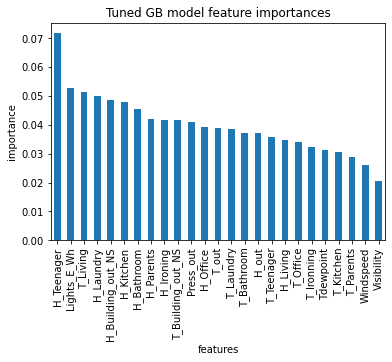

In [93]:
pd.Series(gb_tuned.feature_importances_, index=X_train.columns).abs().sort_values(ascending= False).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Tuned GB model feature importances');

#### The top six features from Tuned GB model are:

H_Teenager, Lights_E_Wh, T_Living, H_Laundry, H_Building_out_NS, H_Kitchen. 

### 5.2) Comparing Prediction and Actual Values from Tuned GB model

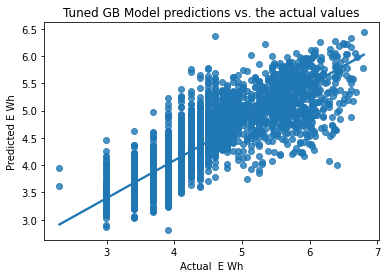

In [218]:
sns.regplot(y_test,y_pred_gb_tuned)
plt.title("Tuned GB Model predictions vs. the actual values")
plt.xlabel('Actual  E Wh')
plt.ylabel('Predicted E Wh');

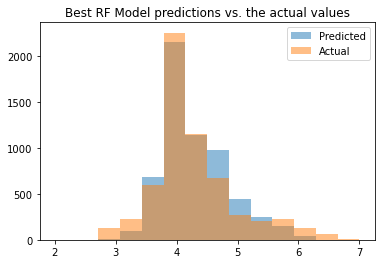

In [102]:
bins = np.linspace(2, 7, 15)
plt.title("Best RF Model predictions vs. the actual values")
plt.hist(y_pred_gb_tuned , bins, alpha=0.5, label='Predicted')
plt.hist(y_test, bins, alpha=0.5, label='Actual')
plt.legend(loc='upper right')
plt.show()

#### We get much better results from the tuned model

### 5.3) Model Performance and Comparision to Base GB Model

In [95]:
gb_tuned_tr_score = gb_tuned.score(X_train_scaled, y_train)  # training set accuracy 
gb_tuned_tr_score

0.9999999999999806

In [97]:
gb_tuned_te_score = gb_tuned.score(X_test_scaled, y_test)  # test set accuracy 
gb_tuned_te_score

0.7135923439360479

In [96]:
100*(gb_tuned_tr_score - gb_tr_score)/ gb_tr_score  # 132% improvement in R2 score on training set!!!

131.89579060491363

In [98]:
100*(gb_tuned_te_score - gb_te_score)/gb_te_score # 88% improvement in R2 score on test set!!!

88.1488983565387

In [103]:
mae_gb_tuned = mean_absolute_error(y_test, y_pred_gb_tuned)
mae_gb_tuned

0.2347823801885913

In [104]:
100 * (mae_gb- mae_gb_tuned)/ mae_gb  # about 35% improvement in MAE score 

34.72295822930974

In [105]:
mape_gb_tuned = mean_absolute_percentage_error(y_test, y_pred_gb_tuned)
mape_gb_tuned

0.053734452667502014

In [106]:
100 * (mape_gb-mape_gb_tuned)/ mape_gb # about 34% improvement in MAPE score

34.14856206861894

# 6) Extreme Gradient Boosting

In [12]:
import xgboost
print(xgboost.__version__)

1.6.0


In [13]:
from xgboost import XGBRegressor

In [14]:
xgb = XGBRegressor()

In [110]:
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [111]:
y_pred_xgb = xgb.predict(X_test_scaled)

In [112]:
xgb.get_params(deep=True)

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### 6.1) Feature Importance

In [113]:
feature_importance = xgb.feature_importances_
feature_importance

array([0.10376264, 0.01125558, 0.03450962, 0.04581163, 0.02847147,
       0.04394444, 0.03193397, 0.03795356, 0.02234082, 0.04831047,
       0.03205042, 0.03141147, 0.02993861, 0.04744106, 0.03208712,
       0.04782281, 0.04731055, 0.05622199, 0.04207338, 0.02383097,
       0.03523534, 0.07704584, 0.0338928 , 0.02040991, 0.03493351],
      dtype=float32)

In [114]:
xgb_coef= pd.DataFrame(feature_importance , index = X.columns, columns = ['Coef'])

xgb_coef.sort_values(by = ['Coef'], ascending = False)

,Coef
Lights_E_Wh,0.103763
H_out,0.077046
T_Parents,0.056222
T_Bathroom,0.048310
T_Teenager,0.047823
T_Ironning,0.047441
H_Teenager,0.047311
T_Living,0.045812
T_Laundry,0.043944
H_Parents,0.042073


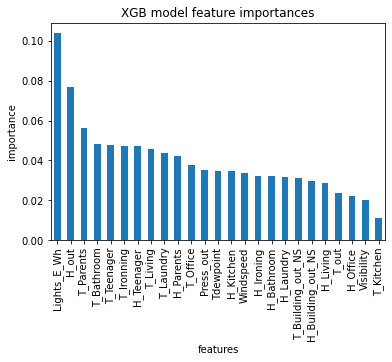

In [124]:
pd.Series(xgb.feature_importances_, index=X_train.columns).abs().sort_values(ascending= False).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('XGB model feature importances');

#### The top six features from XGB model are:

Lights_E_Wh, H_out, T_Parents, T_Bathroom, T_Teenager, and T_Ironning. 	

### 6.2) Comparing Prediction and Actual Values from XGB model

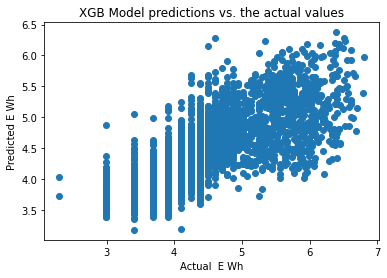

In [119]:
plt.scatter(y_test,y_pred_xgb)
plt.title("XGB Model predictions vs. the actual values")
plt.xlabel('Actual  E Wh')
plt.ylabel('Predicted E Wh');

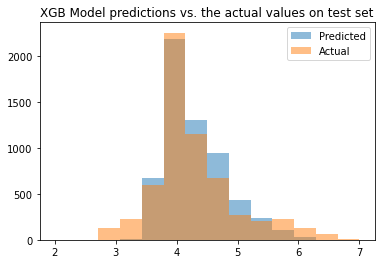

In [120]:
bins = np.linspace(2, 7, 15)
plt.title("XGB Model predictions vs. the actual values on test set")
plt.hist(y_pred_xgb , bins, alpha=0.5, label='Predicted')
plt.hist(y_test, bins, alpha=0.5, label='Actual')
plt.legend(loc='upper right')
plt.show()

#### GB underestimates the smaller values and tend to overestimate the middle range target values

### 6.3) Model Performance

In [116]:
xgb_tr_score = xgb.score(X_train_scaled, y_train)  # training set accuracy 
xgb_tr_score 

0.8498276825837924

In [117]:
xgb_te_score = xgb.score(X_test_scaled, y_test) # test set accuracy 
xgb_te_score 

0.6184469688532104

##### The accuracy of XGB model is higher compared to the linear and GB model, but lower than the RF model

In [121]:
mae_xgb = mean_absolute_error(y_test, y_pred_xgb) # MAE
mae_xgb

0.27391658663318746

In [122]:
mape_xgb= mean_absolute_percentage_error(y_test, y_pred_xgb)  #MAPE
mape_xgb

0.06263141667808997

##### The accuracy of GB model increased compared to the linear model, but lower than the RF model

## 7) Tuned XGradientBoosting (After Hyperparameter tunning)

In [31]:
xgb_tuned= XGBRegressor(n_estimators = 1800, max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7,
 colsample_bylevel = 0.4, )

In [125]:
xgb_tuned.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.4, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1800,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [126]:
y_pred_xgb_tuned= xgb_tuned.predict(X_test_scaled)

In [127]:
xgb_tuned.get_params(deep=True)

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 0.4,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.01,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 20,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 1800,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### 7.1) Feature Importance

In [128]:
xgb_tuned.feature_importances_

array([0.16761008, 0.01474894, 0.02433363, 0.03539318, 0.01973659,
       0.0314878 , 0.02622608, 0.03041401, 0.02502832, 0.03712509,
       0.02701176, 0.02892811, 0.03699753, 0.03888744, 0.03400956,
       0.05169448, 0.05317457, 0.05864563, 0.04095198, 0.02838651,
       0.04008189, 0.05735622, 0.0390273 , 0.02004135, 0.03270193],
      dtype=float32)

In [131]:
xgb_tuned_coef= pd.DataFrame(xgb_tuned.feature_importances_ , index = X.columns, columns = ['Coef'])
xgb_tuned_coef.sort_values(by = ['Coef'], ascending = False)

,Coef
Lights_E_Wh,0.167610
T_Parents,0.058646
H_out,0.057356
H_Teenager,0.053175
T_Teenager,0.051694
H_Parents,0.040952
Press_out,0.040082
Windspeed,0.039027
T_Ironning,0.038887
T_Bathroom,0.037125


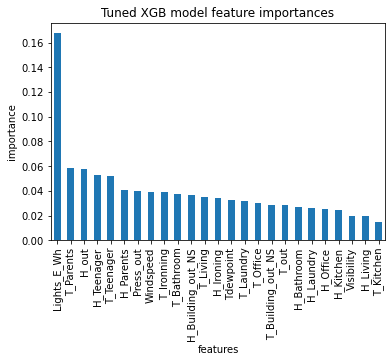

In [224]:
pd.Series(xgb_tuned.feature_importances_, index=X_train.columns).abs().sort_values(ascending= False).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Tuned XGB model feature importances');

#### The top six features from Tuned GB model are:

Lights_E_Wh, T_Parents, H_out, H_Teenager, T_Teenager, and H_Parents.  

### 7.2) Comparing Prediction and Actual Values from Tuned XGB model

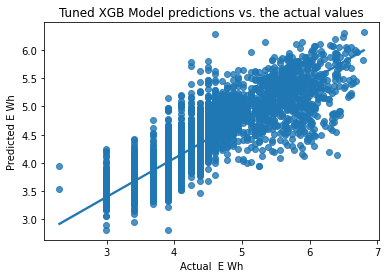

In [220]:
sns.regplot(y_test,y_pred_xgb_tuned)
plt.title("Tuned XGB Model predictions vs. the actual values")
plt.xlabel('Actual  E Wh')
plt.ylabel('Predicted E Wh');

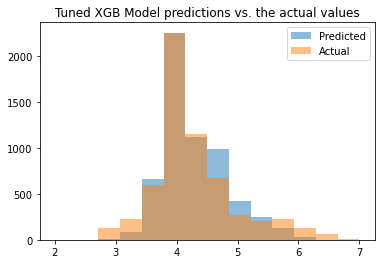

In [222]:
bins = np.linspace(2, 7, 15)
plt.title("Tuned XGB Model predictions vs. the actual values")
plt.hist(y_pred_xgb_tuned , bins, alpha=0.5, label='Predicted')
plt.hist(y_test, bins, alpha=0.5, label='Actual')
plt.legend(loc='upper right')
plt.show()

### 7.3) Model Performance and Comparision to Base XGB Model

In [133]:
xgb_tuned_tr_score = xgb_tuned.score(X_train_scaled, y_train)  # training set accuracy 
xgb_tuned_tr_score

0.9997351566249438

In [135]:
xgb_tuned_te_score = xgb_tuned.score(X_test_scaled, y_test)  # test set accuracy 
xgb_tuned_te_score

0.7283321563889109

#### We get better results from the tuned XGB model

In [134]:
100*(xgb_tuned_tr_score - xgb_tr_score)/ xgb_tr_score  # 17% improvement in R2 score on training set!!!

17.63974945901703

In [136]:
100*(xgb_tuned_te_score - xgb_te_score)/xgb_te_score # 18% improvement in R2 score on test set!!!

17.767924020949

In [505]:
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)
mae_xgb_tuned

0.22615740095822898

In [506]:
100 * (mae_xgb- mae_xgb_tuned)/ mae_xgb  # about 17% improvement in MAE score 

17.43566764684997

In [507]:
mape_xgb_tuned = mean_absolute_percentage_error(y_test, y_pred_xgb_tuned)
mape_xgb_tuned

0.051643808897249024

In [508]:
100 * (mape_xgb-mape_xgb_tuned)/ mape_xgb # about 17.5% improvement in MAPE score

17.54328476603767

# Automating model evaluations

In [516]:
def evaluate_model(X, y, model):
    # define model evaluation method
    cv = RepeatedKFold(n_splits= 5, n_repeats=2, random_state=42)
    # evaluate model
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    
    return scores, print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# 1) Base Models

# 1.1) Linear Model 

In [512]:
evaluate_model(X,y,lm)

0.27 accuracy with a standard deviation of 0.01


(array([0.28180132, 0.25301526, 0.28296876, 0.26880273, 0.27461642,
        0.28669887, 0.27032389, 0.27894175, 0.27024226, 0.24936074,
        0.27526097, 0.24667275, 0.2764245 , 0.29031137, 0.26927849]),
 None)

# 1.2) GB

In [514]:
evaluate_model(X,y,gb)

0.39 accuracy with a standard deviation of 0.01


(array([0.38286818, 0.36837088, 0.39354046, 0.39232934, 0.39337339,
        0.39751842, 0.38786357, 0.38837896, 0.37574353, 0.37833358,
        0.37857152, 0.37821221, 0.38609229, 0.40076218, 0.38720613]),
 None)

# 1.3) XGB

In [515]:
evaluate_model(X,y,xgb)

0.63 accuracy with a standard deviation of 0.01


(array([0.62620962, 0.61838339, 0.63462242, 0.64296189, 0.63255087,
        0.63810689, 0.63050645, 0.63208468, 0.60428864, 0.6314323 ,
        0.63890478, 0.62472988, 0.63933831, 0.63798251, 0.62277011]),
 None)

# 1.4) RandomForest

In [513]:
evaluate_model(X,y,rf)

0.69 accuracy with a standard deviation of 0.01


(array([0.69281657, 0.66853299, 0.69042841, 0.69276411, 0.67378263,
        0.69017259, 0.69228299, 0.69043374, 0.6654769 , 0.68569466,
        0.68962252, 0.67522227, 0.69357547, 0.69514632, 0.68868573]),
 None)

# 2) Tuned Models Performances

# 2.1) GB

In [517]:
evaluate_model(X,y,gb_tuned)

0.72 accuracy with a standard deviation of 0.01


(array([0.74448192, 0.70658206, 0.72572538, 0.72332648, 0.71650006,
        0.72625958, 0.73040024, 0.72240527, 0.7058312 , 0.73550568]),
 None)

# 2.2) XGB

In [518]:
evaluate_model(X,y,xgb_tuned)

0.74 accuracy with a standard deviation of 0.01


(array([0.75471367, 0.71945012, 0.74294935, 0.73858889, 0.72552161,
        0.7428047 , 0.74644743, 0.73984911, 0.72993385, 0.7488089 ]),
 None)

# 2.3) RandomForest

In [519]:
evaluate_model(X,y,rf_tuned)

0.74 accuracy with a standard deviation of 0.01


(array([0.75413639, 0.71544234, 0.7396085 , 0.73269466, 0.72469311,
        0.73967788, 0.73846763, 0.74124318, 0.72311331, 0.74236133]),
 None)

# Hyperparameter Tuning Using RandomizedSearchCV

In [129]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## 1) RandomForest

In [234]:
# parameter grid 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [236]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [237]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cv = RepeatedKFold(n_splits= 3, n_repeats=1, random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)

In [310]:
rf_random_results = pd.DataFrame(rf_random.cv_results_)
rf_random_results.sort_values(by = ['mean_test_score'], ascending = False)[['params', 'mean_test_score']]

,params,mean_test_score
25,"{'n_estimators': 400, 'min_samples_split': 2, ...",0.707338
21,"{'n_estimators': 1600, 'min_samples_split': 5,...",0.703384
32,"{'n_estimators': 800, 'min_samples_split': 5, ...",0.703380
11,"{'n_estimators': 800, 'min_samples_split': 5, ...",0.703380
24,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.703349
...,...,...
26,"{'n_estimators': 1400, 'min_samples_split': 2,...",0.430690
8,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.430486
66,"{'n_estimators': 1800, 'min_samples_split': 2,...",0.381036
9,"{'n_estimators': 1800, 'min_samples_split': 5,...",0.381036


In [238]:
rf_random.fit(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=42),
                   estimator=RandomForestRegressor(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [239]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [243]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} '.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [323]:
rf_base_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_base_model.fit(X_train_scaled, y_train)
rf_base_accuracy = evaluate(rf_base_model, X_test_scaled, y_test)

Model Performance
Average Error: 0.2493 
Accuracy = 94.32%.


In [324]:
mean_absolute_percentage_error(y_test, rf_base_model.predict(X_test_scaled))

0.056837075327868025

In [320]:
best_random = rf_random.best_estimator_
best_random.fit(X_train_scaled, y_train)
random_accuracy = evaluate(best_random, X_test_scaled, y_test)

Model Performance
Average Error: 0.2273 
Accuracy = 94.80%.


In [325]:
mean_absolute_percentage_error(y_test, best_random.predict(X_test_scaled))

0.05204577750125181

In [326]:
best_random.score(X_test_scaled, y_test)  # test set 

0.7230441238499933

In [327]:
best_random.score(X_train_scaled, y_train)  # trainin set

1.0

### 2) Gradient Boosting

In [13]:
# parameter grid 
# Number of trees in GB
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# learning rate 
learning_rate = [0.1, 0.3, 0.5, 0.75]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Number of iterations before no change
n_iter_no_change: [1,5,10]

In [269]:
gb_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'learning_rate': learning_rate
               }
print(gb_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'learning_rate': [0.1, 0.3, 0.5, 0.75]}


In [271]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingRegressor(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cv = RepeatedKFold(n_splits= 3, n_repeats=1, random_state=42)
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = gb_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)

In [272]:
gb_random.fit(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=42),
                   estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.3, 0.5, 0.75],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [274]:
gb_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 60,
 'learning_rate': 0.1}

In [298]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} '.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [334]:
gb_base_model = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
gb_base_model.fit(X_train_scaled, y_train)
gb_base_accuracy = evaluate(gb_base_model, X_test_scaled, y_test)

Model Performance
Average Error: 0.3596 
Accuracy = 91.84%.


In [335]:
best_gb = gb_random.best_estimator_
best_gb.fit(X_train_scaled, y_train)
gb_accuracy = evaluate(best_gb, X_test_scaled, y_test)

Model Performance
Average Error: 0.2336 
Accuracy = 94.65%.


In [336]:
mean_absolute_percentage_error(y_test, gb_base_model.predict(X_test_scaled))

0.08159473817188871

In [337]:
mean_absolute_percentage_error(y_test, best_gb.predict(X_test_scaled))

0.05350434479542793

In [338]:
best_gb.score(X_test_scaled, y_test)  # test set

0.720563280100552

In [339]:
best_gb.score(X_train_scaled, y_train)  # training set

0.9999999999999842

### 3) Extreme Gradient Boosting

In [15]:
xgb = XGBRegressor()

In [340]:
xgb_grid = {'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': n_estimators}

In [342]:
print(xgb_grid)

{'max_depth': [3, 5, 6, 10, 15, 20], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9]), 'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [343]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBRegressor(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cv = RepeatedKFold(n_splits= 3, n_repeats=1, random_state=42)
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = xgb_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)

In [344]:
xgb_random.fit(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=42),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interactio...
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([

In [346]:
xgb_random.best_params_

{'subsample': 0.5,
 'n_estimators': 1800,
 'max_depth': 20,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.4}

In [348]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.2f} '.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [349]:
xgb_base_model = XGBRegressor(n_estimators = 100, random_state = 42)
xgb_base_model.fit(X_train_scaled, y_train)
xgb_base_accuracy = evaluate(xgb_base_model, X_test_scaled, y_test)

Model Performance
Average Error: 0.27 
Accuracy = 93.74%.


In [350]:
best_xgb = xgb_random.best_estimator_
best_xgb.fit(X_train_scaled, y_train)
xgb_accuracy = evaluate(best_xgb, X_test_scaled, y_test)

Model Performance
Average Error: 0.23 
Accuracy = 94.82%.


In [351]:
mean_absolute_percentage_error(y_test, xgb_base_model.predict(X_test_scaled))

0.06263141667808995

In [352]:
mean_absolute_percentage_error(y_test, best_xgb.predict(X_test_scaled))

0.05183047837312046

In [353]:
best_xgb.score(X_test_scaled, y_test)  

0.7314057019772948

In [354]:
best_xgb.score(X_train_scaled, y_train)  

0.9985770514715532

# Making Predictions 

## Case 1) High Humidity in House

In [34]:
X_pred_humd = X.loc[0,:]   
X_pred_humd

Lights_E_Wh           30.000000
T_Kitchen             19.890000
H_Kitchen             47.596667
T_Living              19.200000
H_Living              44.790000
T_Laundry             19.790000
H_Laundry             44.730000
T_Office              19.000000
H_Office              45.566667
T_Bathroom            17.166667
H_Bathroom            55.200000
T_Building_out_NS      7.026667
H_Building_out_NS     84.256667
T_Ironning            17.200000
H_Ironing             41.626667
T_Teenager            18.200000
H_Teenager            48.900000
T_Parents             17.033333
H_Parents             45.530000
T_out                  6.600000
Press_out            733.500000
H_out                 92.000000
Windspeed              7.000000
Visibility            63.000000
Tdewpoint              5.300000
Name: 0, dtype: float64

In [96]:
X_pred_humd['H_Kitchen','H_Living', 'H_Laundry','H_Bathroom', 'H_Teenager','H_Office', 'H_Ironing', 'H_Parents'] = 80 # setting inside humedity to 80% 
X_pred_humd

C:\Users\msale\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\msale\anaconda3\lib\site-packages\pandas\core\indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()
C:\Users\msale\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Lights_E_Wh           80.000000
T_Kitchen             19.890000
H_Kitchen             80.000000
T_Living              19.200000
H_Living              80.000000
T_Laundry             19.790000
H_Laundry             80.000000
T_Office              19.000000
H_Office              80.000000
T_Bathroom            17.166667
H_Bathroom            80.000000
T_Building_out_NS      7.026667
H_Building_out_NS     84.256667
T_Ironning            17.200000
H_Ironing             80.000000
T_Teenager            18.200000
H_Teenager            80.000000
T_Parents             17.033333
H_Parents             80.000000
T_out                  6.600000
Press_out            733.500000
H_out                 92.000000
Windspeed              7.000000
Visibility            63.000000
Tdewpoint              5.300000
Name: 0, dtype: float64

In [97]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_pred_humd_scaled = scaler.transform(X_pred_humd.array.reshape(1,-1))

In [101]:
xgb_tuned.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.4, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1800,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [100]:
y_pred_humd = xgb_tuned.predict(X_pred_humd_scaled)
y_pred_humd

array([4.6990232], dtype=float32)